In [1]:
import cv2, numpy as np, matplotlib.pyplot as plt, os
from tqdm import tqdm
from torchvision import transforms
from torchvision.datasets import ImageFolder
from torchvision import transforms, datasets
from PIL import Image
import torch
import torch.nn as nn
import torch.nn.functional as F
import os
from PIL import Image
from torchvision.datasets import ImageFolder
from torchvision.transforms import ToTensor
from torch.utils.data import DataLoader
import torch.optim as optim


In [2]:
# Set the path to your dataset folder
dataset_path = '/home/ojmaha/Documents/SoC/archive (1)/dog vs cat/dataset/training_set'

# Define the transformations to be applied to each image
transform = transforms.Compose([
    transforms.Grayscale(),
    transforms.Resize((50, 50)),  # Resize the images to a specific size
    transforms.ToTensor(),          # Convert the images to tensors
    ])

# Function to check if a file is a valid JPEG image
def is_valid_image(file_path):
    try:
        with Image.open(file_path) as img:
            img.verify()
            return True
    except (IOError, SyntaxError) as e:
        return False

# Custom Dataset class to handle corrupted or non-JPEG files
class CustomImageFolder(ImageFolder):
    def __getitem__(self, index):
        path, target = self.samples[index]
        if self.transform is not None:
            try:
                img = self.transform(Image.open(path))
                return img, target
            except (IOError, SyntaxError) as e:
                pass

# Create the CustomImageFolder dataset
dataset = CustomImageFolder(root=dataset_path, transform=transform)

# Create the DataLoader
dataloader = DataLoader(dataset, batch_size=len(dataset), shuffle=True)

for X, y in dataloader:
    break  # Since we only need to iterate once to get the entire dataset

print(dataset)


Dataset CustomImageFolder
    Number of datapoints: 8000
    Root location: /home/ojmaha/Documents/SoC/archive (1)/dog vs cat/dataset/training_set
    StandardTransform
Transform: Compose(
               Grayscale(num_output_channels=1)
               Resize(size=(50, 50), interpolation=bilinear, max_size=None, antialias=warn)
               ToTensor()
           )


In [3]:
print(dataset[0][0].shape
     )

torch.Size([1, 50, 50])


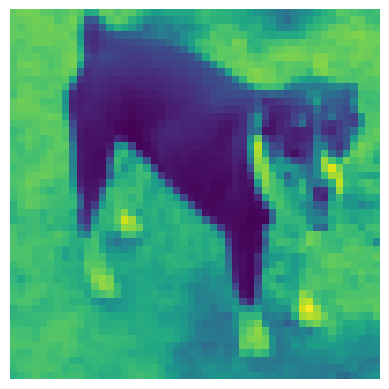

In [4]:

# Select a cat image from the dataset
cat_image_index = 7689  # Adjust this index according to the image you want to display

# Access the image tensor from the dataset
cat_image_tensor, f = dataset[cat_image_index]

# Convert the image tensor to a NumPy array
cat_image_np = cat_image_tensor.numpy()
# Transpose the array to match the shape expected by Matplotlib (C, H, W -> H, W, C)
cat_image_np = cat_image_np.transpose(1, 2, 0)

# Display the cat image
plt.imshow(cat_image_np)
plt.axis('off')  # Turn off axis ticks and labels
plt.show()


In [5]:
class Net(nn.Module):
    def __init__(self):
        super().__init__() # just run the init of parent class (nn.Module)
        self.conv1 = nn.Conv2d(1, 32, 5) # input is 1 image, 32 output channels, 5x5 kernel / window
        self.conv2 = nn.Conv2d(32, 64, 5) # input is 32, bc the first layer output 32. Then we say the output will be 64 channels, 5x5 kernel / window
        self.conv3 = nn.Conv2d(64, 128, 5)

        x = torch.randn(50,50).view(-1,1,50,50)
        self._to_linear = None
        self.convs(x)

        self.fc1 = nn.Linear(self._to_linear, 512) #flattening.
        self.fc2 = nn.Linear(512, 1) # 512 in, 2 out bc we're doing 2 classes (dog vs cat).

    def convs(self, x):
        # max pooling over 2x2
        x = F.max_pool2d(F.relu(self.conv1(x)), (2, 2))
        x = F.max_pool2d(F.relu(self.conv2(x)), (2, 2))
        x = F.max_pool2d(F.relu(self.conv3(x)), (2, 2))

        if self._to_linear is None:
            self._to_linear = x[0].shape[0]*x[0].shape[1]*x[0].shape[2]
        return x

    def forward(self, x):
        x = self.convs(x)
        x = x.view(-1, self._to_linear)  # .view is reshape ... this flattens X before 
        x = F.relu(self.fc1(x))
        x = self.fc2(x) # bc this is our output layer. No activation here.
        return x.squeeze(1)


net = Net()
print(net)

Net(
  (conv1): Conv2d(1, 32, kernel_size=(5, 5), stride=(1, 1))
  (conv2): Conv2d(32, 64, kernel_size=(5, 5), stride=(1, 1))
  (conv3): Conv2d(64, 128, kernel_size=(5, 5), stride=(1, 1))
  (fc1): Linear(in_features=512, out_features=512, bias=True)
  (fc2): Linear(in_features=512, out_features=1, bias=True)
)


In [6]:
X = []
for i in dataset:
    X.append(torch.Tensor(i[0]).view(-1, 50, 50))

X = torch.stack(X, dim=0)
X = X/255.0
y = torch.Tensor([i[1] for i in dataset])
VAL_PCT = 0.1  # lets reserve 10% of our data for validation
val_size = int(len(X)*VAL_PCT)
print(val_size)

train_X = X[:-val_size]
train_y = y[:-val_size]

test_X = X[-val_size:]
test_y = y[-val_size:]
print(len(train_X), len(test_X))

800
7200 800


In [9]:
optimizer = optim.Adam(net.parameters(), lr=0.001)
loss_function = nn.BCEWithLogitsLoss()
BATCH_SIZE = 100
EPOCHS = 1

for epoch in range(EPOCHS):
    for i in tqdm(range(0, len(train_X), BATCH_SIZE)): # from 0, to the len of x, stepping BATCH_SIZE at a time. [:50] ..for now just to dev
        batch_X = train_X[i:i+BATCH_SIZE].view(-1, 1, 50, 50)
        batch_y = train_y[i:i + BATCH_SIZE].unsqueeze(1).float()

        net.zero_grad()

        outputs = net(batch_X)
        print(outputs[0])
        print(batch_y[0])
        loss = loss_function(outputs, batch_y.view(100))
        loss.backward()
        optimizer.step()    # Does the update

    print(f"Epoch: {epoch}. Loss: {loss}")


  0%|                                                    | 0/72 [00:00<?, ?it/s]

tensor(-0.0102, grad_fn=<SelectBackward0>)
tensor([0.])


  6%|██▍                                         | 4/72 [00:02<00:32,  2.07it/s]

tensor(-0.1022, grad_fn=<SelectBackward0>)
tensor([0.])
tensor(-0.2868, grad_fn=<SelectBackward0>)
tensor([0.])
tensor(-0.6472, grad_fn=<SelectBackward0>)
tensor([0.])


  8%|███▋                                        | 6/72 [00:03<00:18,  3.48it/s]

tensor(-1.2946, grad_fn=<SelectBackward0>)
tensor([0.])
tensor(-2.3900, grad_fn=<SelectBackward0>)
tensor([0.])
tensor(-4.0758, grad_fn=<SelectBackward0>)
tensor([0.])
tensor(-6.3175, grad_fn=<SelectBackward0>)
tensor([0.])


 14%|█████▉                                     | 10/72 [00:03<00:09,  6.59it/s]

tensor(-8.9702, grad_fn=<SelectBackward0>)
tensor([0.])
tensor(-11.9406, grad_fn=<SelectBackward0>)
tensor([0.])
tensor(-15.1722, grad_fn=<SelectBackward0>)
tensor([0.])
tensor(-18.6450, grad_fn=<SelectBackward0>)
tensor([0.])


 19%|████████▎                                  | 14/72 [00:03<00:06,  9.59it/s]

tensor(-22.0683, grad_fn=<SelectBackward0>)
tensor([0.])
tensor(-25.7313, grad_fn=<SelectBackward0>)
tensor([0.])
tensor(-29.2441, grad_fn=<SelectBackward0>)
tensor([0.])
tensor(-32.7236, grad_fn=<SelectBackward0>)
tensor([0.])


 25%|██████████▊                                | 18/72 [00:03<00:04, 11.78it/s]

tensor(-36.4075, grad_fn=<SelectBackward0>)
tensor([0.])
tensor(-39.6427, grad_fn=<SelectBackward0>)
tensor([0.])
tensor(-42.9296, grad_fn=<SelectBackward0>)
tensor([0.])
tensor(-46.0570, grad_fn=<SelectBackward0>)
tensor([0.])


 31%|█████████████▏                             | 22/72 [00:04<00:03, 13.30it/s]

tensor(-49.1154, grad_fn=<SelectBackward0>)
tensor([0.])
tensor(-51.9947, grad_fn=<SelectBackward0>)
tensor([0.])
tensor(-54.5294, grad_fn=<SelectBackward0>)
tensor([0.])
tensor(-57.1026, grad_fn=<SelectBackward0>)
tensor([0.])


 36%|███████████████▌                           | 26/72 [00:04<00:03, 13.24it/s]

tensor(-59.5736, grad_fn=<SelectBackward0>)
tensor([0.])
tensor(-62.1635, grad_fn=<SelectBackward0>)
tensor([0.])
tensor(-63.7761, grad_fn=<SelectBackward0>)
tensor([0.])


 39%|████████████████▋                          | 28/72 [00:04<00:03, 12.23it/s]

tensor(-65.4652, grad_fn=<SelectBackward0>)
tensor([0.])
tensor(-67.8439, grad_fn=<SelectBackward0>)
tensor([0.])
tensor(-69.5320, grad_fn=<SelectBackward0>)
tensor([0.])


 42%|█████████████████▉                         | 30/72 [00:04<00:03, 12.19it/s]

tensor(-70.8556, grad_fn=<SelectBackward0>)
tensor([0.])
tensor(-72.5173, grad_fn=<SelectBackward0>)
tensor([0.])


 44%|███████████████████                        | 32/72 [00:05<00:03, 10.49it/s]

tensor(-73.5647, grad_fn=<SelectBackward0>)
tensor([0.])
tensor(-75.0595, grad_fn=<SelectBackward0>)
tensor([0.])


 49%|████████████████████▉                      | 35/72 [00:05<00:04,  8.39it/s]

tensor(-76.3260, grad_fn=<SelectBackward0>)
tensor([0.])
tensor(-77.5618, grad_fn=<SelectBackward0>)
tensor([0.])


 51%|██████████████████████                     | 37/72 [00:05<00:04,  7.08it/s]

tensor(-78.0946, grad_fn=<SelectBackward0>)
tensor([0.])
tensor(-79.0905, grad_fn=<SelectBackward0>)
tensor([0.])


 53%|██████████████████████▋                    | 38/72 [00:06<00:05,  6.46it/s]

tensor(-80.0348, grad_fn=<SelectBackward0>)
tensor([0.])


 54%|███████████████████████▎                   | 39/72 [00:06<00:05,  5.65it/s]

tensor(-80.9075, grad_fn=<SelectBackward0>)
tensor([0.])


 58%|█████████████████████████                  | 42/72 [00:06<00:04,  6.71it/s]

tensor(-81.4407, grad_fn=<SelectBackward0>)
tensor([1.])
tensor(-68.9472, grad_fn=<SelectBackward0>)
tensor([1.])
tensor(-54.7676, grad_fn=<SelectBackward0>)
tensor([1.])
tensor(-40.8940, grad_fn=<SelectBackward0>)
tensor([1.])


 64%|███████████████████████████▍               | 46/72 [00:07<00:02, 10.09it/s]

tensor(-29.1739, grad_fn=<SelectBackward0>)
tensor([1.])
tensor(-19.6741, grad_fn=<SelectBackward0>)
tensor([1.])
tensor(-12.6705, grad_fn=<SelectBackward0>)
tensor([1.])
tensor(-7.7784, grad_fn=<SelectBackward0>)
tensor([1.])


 69%|█████████████████████████████▊             | 50/72 [00:07<00:01, 12.29it/s]

tensor(-4.5558, grad_fn=<SelectBackward0>)
tensor([1.])
tensor(-2.5126, grad_fn=<SelectBackward0>)
tensor([1.])
tensor(-1.3043, grad_fn=<SelectBackward0>)
tensor([1.])


 72%|███████████████████████████████            | 52/72 [00:07<00:01, 12.70it/s]

tensor(-0.6313, grad_fn=<SelectBackward0>)
tensor([1.])
tensor(-0.2889, grad_fn=<SelectBackward0>)
tensor([1.])
tensor(-0.1338, grad_fn=<SelectBackward0>)
tensor([1.])


 78%|█████████████████████████████████▍         | 56/72 [00:07<00:01, 12.42it/s]

tensor(-0.0732, grad_fn=<SelectBackward0>)
tensor([1.])
tensor(-0.0456, grad_fn=<SelectBackward0>)
tensor([1.])
tensor(-0.0265, grad_fn=<SelectBackward0>)
tensor([1.])


 81%|██████████████████████████████████▋        | 58/72 [00:07<00:01, 12.39it/s]

tensor(-0.0132, grad_fn=<SelectBackward0>)
tensor([1.])
tensor(-0.0060, grad_fn=<SelectBackward0>)
tensor([1.])
tensor(0.0002, grad_fn=<SelectBackward0>)
tensor([1.])


 86%|█████████████████████████████████████      | 62/72 [00:08<00:00, 12.15it/s]

tensor(0.0140, grad_fn=<SelectBackward0>)
tensor([1.])
tensor(0.0328, grad_fn=<SelectBackward0>)
tensor([1.])
tensor(0.0526, grad_fn=<SelectBackward0>)
tensor([1.])


 89%|██████████████████████████████████████▏    | 64/72 [00:08<00:00, 12.11it/s]

tensor(0.0728, grad_fn=<SelectBackward0>)
tensor([1.])
tensor(0.0936, grad_fn=<SelectBackward0>)
tensor([1.])
tensor(0.1146, grad_fn=<SelectBackward0>)
tensor([1.])


 94%|████████████████████████████████████████▌  | 68/72 [00:08<00:00, 12.43it/s]

tensor(0.1368, grad_fn=<SelectBackward0>)
tensor([1.])
tensor(0.1606, grad_fn=<SelectBackward0>)
tensor([1.])
tensor(0.1864, grad_fn=<SelectBackward0>)
tensor([1.])


 97%|█████████████████████████████████████████▊ | 70/72 [00:08<00:00, 11.78it/s]

tensor(0.2147, grad_fn=<SelectBackward0>)
tensor([1.])
tensor(0.2466, grad_fn=<SelectBackward0>)
tensor([1.])


100%|███████████████████████████████████████████| 72/72 [00:09<00:00,  7.86it/s]

tensor(0.2830, grad_fn=<SelectBackward0>)
tensor([1.])
Epoch: 0. Loss: 0.5616323947906494


In [10]:
correct = 0
total = 0
with torch.no_grad():
    for i in tqdm(range(len(test_X))):
        real_class = torch.argmax(test_y[i])
        net_out = net(test_X[i].view(-1, 1, 50, 50))[0]  # returns a list, 
        predicted_class = torch.argmax(net_out)

        if predicted_class == real_class:
            correct += 1
        total += 1
print("Accuracy: ", round(correct/total, 3))

100%|███████████████████████████████████████| 800/800 [00:00<00:00, 1119.79it/s]

Accuracy:  1.0
